In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

### 1. Получите данные и загрузите их в рабочую среду

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### 2. Подготовьте датасет к обучению моделей:
- a) Категориальные переменные переведите в цифровые значения. Можно использовать pd.get_dummies, preprocessing.LabelEncoder. Старайтесь не использовать для этой задачи циклы

In [3]:
from sklearn.preprocessing import StandardScaler

to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

df[to_scale] = StandardScaler().fit_transform(df[to_scale])

In [4]:
cats = df.select_dtypes('object').columns
df = pd.get_dummies(df, columns=cats)
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,0,1.382928,-0.832432,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,-0.478484,1.491752,-0.171961,0,0.754157,0.105664,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.129513,0.770188,0,-1.525138,-0.832432,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,-0.584556,0.302825,0.139040,0,-1.132156,0.574711,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,0.051881,0.951331,-0.034755,0,-0.581981,-0.832432,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


### 3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 4. Обучите модель логистической регрессии с параметрами по умолчанию

### 5. Подсчитайте основные метрики модели. Используйте следующие метрики и функцию:
cross_validate(…, cv=10, scoring=[‘accuracy’,‘recall’,‘precision’,‘f1’])

### 6. Оптимизируйте 3-4 параметра модели:
- a) Используйте GridSearchCV.
- b) Используйте RandomizedSearchCV.
- c) *Добавьте в п. 6b 2-5 моделей классификации и вариации их параметров.
- d) Повторите п. 5 после каждого итогового изменения параметров.

**Поскольку на тренировочной выборке я буду использовать кросс-валидацию для подбора гиперпараметров классификаторов, то подсчет метрик качества я буду выполнять на отложенной тестовой выборке. В таком случае я не вижу смысла использовать функцию `cross_validate` на тестовой выборке, равно как и не вижу смысла использовать ее на тренировочной выборке, так как подбор гиперпараметров также выполняется на `X_train`.**

**Я напишу функцию, которая будет подбирать гиперпараметры и обучать модель на тренировочной выборке, а рассчитывать метрики на тестовой выборке и добавлять их в датафрейм для дальнейшего сравнения. Каждый тип классификатора я буду обучать 3 раза: без подбора, с подбором с помощью `GridSearchCV`, и с помощью `RandomizedSearchCV`. Также я буду замерять время обучения каждой модели.**

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

results = pd.DataFrame(columns=['classification_model', 'optimization_method', 'overall_time',
                                'accuracy', 'recall', 'precision', 'f1_score'])

def to_results(clf):
    
    model_none = clf
    model_grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    model_rand = RandomizedSearchCV(clf, param_grid, cv=10, scoring='accuracy', n_iter=20, n_jobs=-1, random_state=0)
    
    models = [model_none, model_grid, model_rand]
    opimizers = ['None', 'Grid', 'Random']

    for model, optimizer in zip(models, opimizers):
        start_time = time.time()
        model.fit(X_train, y_train)
        the_time = time.time() - start_time
    
        if model != clf:
            model = model.best_estimator_
        
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        pre = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
    
        results.loc[len(results)] = [clf.__class__.__name__, optimizer, the_time, acc, rec, pre, f1]
    
    return results.iloc[-3:]

In [7]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 9),
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000, 2500, 5000]
}

to_results(LogisticRegression(random_state=42))

,classification_model,optimization_method,overall_time,accuracy,recall,precision,f1_score
0,LogisticRegression,None,0.003379,0.885870,0.931373,0.87156,0.900474
1,LogisticRegression,Grid,8.740742,0.891304,0.931373,0.87963,0.904762
2,LogisticRegression,Random,0.237395,0.891304,0.931373,0.87963,0.904762


In [8]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': list(range(1,31)),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan', 'cosine']
}

to_results(KNeighborsClassifier())

,classification_model,optimization_method,overall_time,accuracy,recall,precision,f1_score
3,KNeighborsClassifier,None,0.000000,0.896739,0.911765,0.902913,0.907317
4,KNeighborsClassifier,Grid,1.618337,0.923913,0.941176,0.923077,0.932039
5,KNeighborsClassifier,Random,0.226286,0.913043,0.931373,0.913462,0.922330


In [9]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}

to_results(SVC(random_state=42))

,classification_model,optimization_method,overall_time,accuracy,recall,precision,f1_score
6,SVC,None,0.015793,0.896739,0.941176,0.880734,0.909953
7,SVC,Grid,44.353491,0.902174,0.941176,0.888889,0.914286
8,SVC,Random,17.321367,0.875000,0.911765,0.869159,0.889952


In [10]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [None, 2, 3, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

to_results(DecisionTreeClassifier(random_state=42))

,classification_model,optimization_method,overall_time,accuracy,recall,precision,f1_score
9,DecisionTreeClassifier,None,0.000000,0.793478,0.813725,0.813725,0.813725
10,DecisionTreeClassifier,Grid,0.744045,0.820652,0.794118,0.870968,0.830769
11,DecisionTreeClassifier,Random,0.205756,0.820652,0.794118,0.870968,0.830769


In [11]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [None, 2, 3, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

to_results(RandomForestClassifier(random_state=42))

,classification_model,optimization_method,overall_time,accuracy,recall,precision,f1_score
12,RandomForestClassifier,None,0.141116,0.891304,0.911765,0.894231,0.902913
13,RandomForestClassifier,Grid,73.610619,0.891304,0.941176,0.872727,0.905660
14,RandomForestClassifier,Random,5.886659,0.880435,0.931373,0.863636,0.896226


In [12]:
from sklearn.naive_bayes import GaussianNB

param_grid = {
    'var_smoothing': np.logspace(0, -9, 100)
}

to_results(GaussianNB())

,classification_model,optimization_method,overall_time,accuracy,recall,precision,f1_score
15,GaussianNB,None,0.004089,0.885870,0.901961,0.893204,0.897561
16,GaussianNB,Grid,0.965894,0.902174,0.921569,0.903846,0.912621
17,GaussianNB,Random,0.243213,0.896739,0.911765,0.902913,0.907317


###  7. Сформулируйте выводы по проделанной работе:
- a) Сравните метрики построенных моделей.
- b) *Сравните с полученными результатами в домашнем задании по теме «Ансамблирование».

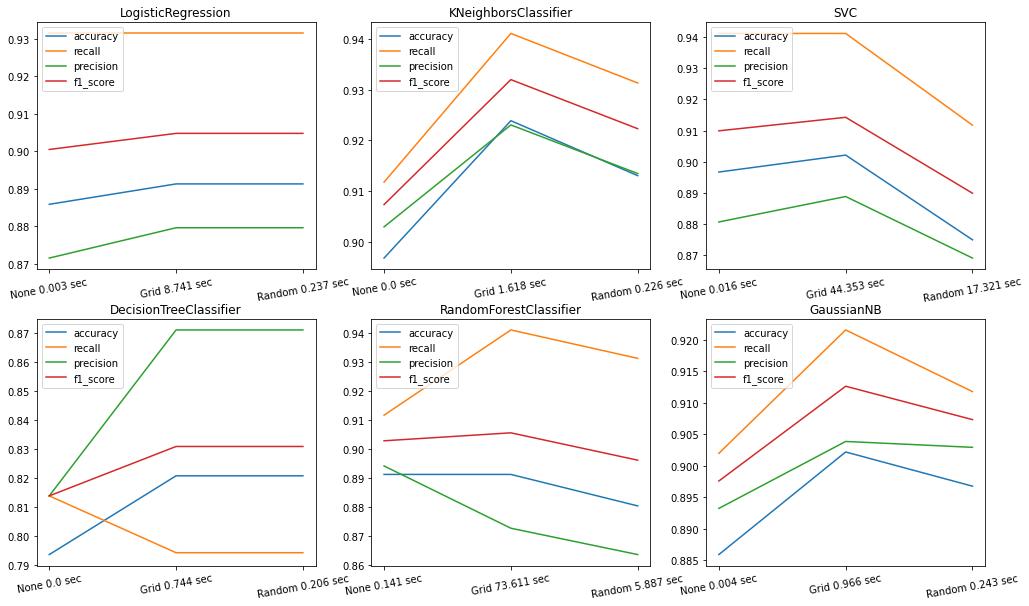

In [13]:
fig = plt.figure(figsize=(17,10))

for i in range(6):
    a = i*3
    b = i*3 + 3
    
    optimizer = results.iloc[a:b]['optimization_method']
    time_ = round(results.iloc[a:b]['overall_time'], 3).astype(str)
    x_axis = optimizer + ' ' + time_ + ' sec'
    
    ax = fig.add_subplot(2, 3, i+1)
    
    for metric in results.columns[-4:]:
        ax.plot(x_axis, results.iloc[a:b][metric], label=metric)
        plt.xticks(rotation=10)
    
    ax.legend(loc='upper left')
    ax.set_title(results['classification_model'][a])

- **`LogisticRegression`** одинаково небольшой прирост качества по всем метрикам (кроме `Recall`) дают оба метода подбора гиперпараметров. Этот прирост нельзя назвать существенным, поэтому можно заключить, что для данной задачи логистическая регрессия в scikit-learn уже достаточно хорошо работает "из коробки".


- **`KNeighborsClassifier`** подбор с помощью `GridSearchCV` дал заметный прирост по всем метрикам. `RandomizedSearchCV` тоже улучшил качество работы базового алгоритма, но уже не так сильно, что закономерно, поскольку он случайно выбирает гиперпараметры из всего набора и не может гарантировать наилучший результат.


- **`SVC`** аналогично логистической регрессии были незначительно улучшены все метрики (кроме `Recall`) в процессе подбора гиперпараметров с помощью `GridSearchCV`. Однако затем `RandomizedSearchCV` не смог справиться с задачей оптимизации, и в итоге все метрики заметно просели в сравнении с моделью "из коробки".


- **`DecisionTreeClassifier`** за исключением `Recall` оба метода подбора гиперпараметров дали одинаково неплохой прирост метрикам, в особенности `Precision`. Этот пример интересен тем, что оптимизация алгоритма даже с поиском по сетке не смогла улучшить все метрики: `Recall` снизился. Возможно это связано с тем, что сетка гиперпараметров не была построена оптимально.


- **`RandomForestClassifier`** уже достаточно сильный алгоритм, поэтому, вероятно, к подбору его гиперпараметров необходимо подходить более основательно. Несмотря на то, что оба метода оптимизации были мною настроены на максимизацию `accuracy`, ни один из них не дал здесь прироста.


- **`GaussianNB`** здесь картина похожа на `KNeighborsClassifier`, за исключением того, что не по всем метрикам настолько очевидна разница между поиском по сетке и случайным поиском гиперпараметров.


Смотря на время обучения базовых алгоритмов, и сравнивая его с тем, что затрачивается на подбор гиперпараметров (особенно с поиском по сетке) можно заключить, что это весьма ресурсоемкая задача, которая потребует вдумчивого и осторожного подхода на больших датасетах. Необходимо добавить, что в рассмотренной работе направление изменения метрик может зависеть от значения `random state`, тем более, что в некоторых случаях эти изменения весьма незначительны.


Если сравнивать улучшение работы классификаторов от подбора гиперпараметров с применением ансамблевых методов, то ансамбли, пожалуй могут дать более быстрый и существенный прирост. Но в конечном счете все будет зависеть от специфики данных и поставленной задачи. К примеру в этой задаче ансамбль `RandomForestClassifier` не показал себя лучше чем логистическая регрессия, или KNN.